# Notes for Structural Dynamic Factor Model
\* Adapted from notes by Rex Du

## Start with a general state space form

$$
\begin{split}
y_t&=Az_t+Bx_t+\mu_t, &\text{ where } \mu_t\sim N(0,\Sigma_{\mu}) \text{ is known as the observation equation} \\
z_t&=Cz_t+Dw_t+v_t, &\text{ where } v_t\sim N(0,\Sigma_{v}) \text{ is known as the state equation}\\
\end{split}
$$

$y_t$ is an $n\times1$ vector of observed endogenous variables; $z_t$ is an $m\times1$ vector of unobserved state variables, $x_t$ is a $k_x\times 1$ vector of observed exogenous variables that enter into the observation equation.

Parameters are: $A(n\times m),B(n\times k_x),C(m\times m),D(m\times k_w).$

# Structural Dynamic Factor Model

$$
\begin{split}
y_t&=Lf_t+B^*x_t^*+u_t, &\text{ where } u_t\sim N(0, \Sigma_u) \\
f_t&=a_t+\gamma_t+D^*w_t^* \\
a_t&= a_{t-1}+\beta_{t-1}+\epsilon_t,  &\text{ where }\epsilon_t\sim N(0, \Sigma_{\epsilon}) \\ 
\beta_t&=\beta_{t-1}+\eta_t, &\text{ where }\nu_t\sim N(0, \Sigma_{\eta}) \\
\gamma_t&=-\sum_{j=1}^{51}\gamma_{t-j}+\xi_t, &\text{ where } \xi_t\sim N(0, \Sigma_{\xi})
\end{split}
$$

# Simulate a SDFM

In [60]:
from scipy.linalg import block_diag
from __future__ import division
# seasonal component:
import numpy as np, pandas as pd
T = 5200 # number of periods.
seasons = 52
n = 5 # number of time series
p = 3 # number of factors
def local_trend_component(p):
    return np.kron(np.triu(np.ones([2,2])), np.eye(p))
def seasonal_component(seasons, p):
    Ip = np.eye(p)
    x = np.kron(np.diag(np.ones(seasons-2), k = -1), Ip)
    y = np.kron(np.ones([1, seasons-1]), -Ip)
    x[:p, :] = y
    return x
def combine_components(listofcomponents):
    return block_diag(*listofcomponents)

In [61]:
def varimax(Phi, gamma = 1.0, q = 20, tol = 1e-6):
    from scipy import eye, asarray, dot, sum
    from scipy.linalg import svd
    from numpy import diag
    p,k = Phi.shape
    R = eye(k)
    d=0
    for i in xrange(q):
        d_old = d
        Lambda = dot(Phi, R)
        u,s,vh = svd(dot(Phi.T,asarray(Lambda)**3 - (gamma/p) * dot(Lambda, diag(diag(dot(Lambda.T,Lambda))))))
        R = dot(u,vh)
        d = sum(s)
        if d_old!=0 and d/d_old < 1 + tol: break
    return dot(Phi, R)

In [62]:
# Loading factors
# L = np.array([[12, 3, -1],[-2,4, -2],[-1,3, -1],[-1.6,9, -2.3],[-.5,.4, -12] ])
L = np.array([[12, 0, 0],[-2,4, 0],[-1,3, -1],[-1.6,9, -2.3],[-.5,.4, -12] ])
# L = varimax(L, q = 50)
# get the eta shocks:
sigma_xi = np.array([[5,0,0],[0, 3, 0], [0,0, 10]])
sigma_epsilon = np.eye(p)
SIG_eps = np.random.multivariate_normal([0,0,0], sigma_epsilon, T)
sigma_eta = np.array([[1.3,0, 0],[0,2., 0], [0,0, 1.0]])
SIG_eta = np.random.multivariate_normal([0,0,0], sigma_eta, T)
sigma_mu = np.diag([3]*n)
# Get the season shock:
T = 5200
# sigma_xi = np.array([[1.5,0, 0],[0,1.8, 0], [0,0, 1.10]])
# SIG_xi = np.random.multivariate_normal([0,0,0], sigma_xi, T)
# C matrix (state design)
C = block_diag(*[local_trend_component(p), seasonal_component(seasons, p)])
SIG = block_diag(*[sigma_epsilon, sigma_eta, sigma_xi, np.zeros([(seasons-2)*p,(seasons-2)*p])])
A = L
for m in [np.zeros([n,p]), L, np.zeros([n,(seasons-2)*p])]:
    A = np.concatenate([A, m], axis = 1)

# Initiate Z
alpha_0 = np.array([[0,0, 0]]).transpose()
beta_0 = np.array([[2,-1.5, 1.4]]).transpose()
gamma_0 = np.random.multivariate_normal([150]*p+[0]*p*(seasons-2),np.diag([3]*p*(seasons-1)), 1).transpose()
Z_0 = alpha_0
for m in [beta_0, gamma_0]:
    Z_0 = np.concatenate([Z_0,m], axis = 0)

# Simulate shocks
latentshocks = np.random.multivariate_normal(np.zeros(SIG.shape[0]), SIG, T-1)

Zts = [Z_0]
Z = Z_0
for shock in latentshocks:
    Z = np.dot(C, Z)+shock.reshape(len(shock), 1)
    Zts.append(Z)

Y = list()
for Z in Zts:
    Y.append((np.dot(A,Z)+np.random.multivariate_normal([0]*n, sigma_mu).reshape(n,1)).reshape(n))
data = pd.DataFrame(Y)
data.columns = ['var_'+str(c+1) for c in range(5)]

Z = pd.DataFrame([z.reshape(len(z))[:p] for z in Zts])
Z.columns = ['factor_'+str(c+1) for c in range(3)]

data = data.merge(Z, left_index = True, right_index = True)
data.reset_index(inplace = True)
data.rename(columns = {'index':'t'}, inplace = True)

In [63]:
data.head()

,t,var_1,var_2,var_3,var_4,var_5,factor_1,factor_2,factor_3
0,0,1754.680685,305.094466,150.642119,767.455624,-1825.926366,0.000000,0.000000,0.000000
1,1,-1602.012688,-340.527731,-181.925823,-835.921734,1710.981616,1.092037,-1.144449,2.035644
2,2,13.174940,11.541272,12.983638,40.065688,63.633326,2.224987,-1.471235,1.248497
3,3,163.100896,-22.778780,-16.719370,-21.216736,-81.288781,5.591329,-1.268190,2.075900
4,4,33.698395,2.952977,3.003201,11.084085,-23.137598,8.059987,-0.215819,1.335917


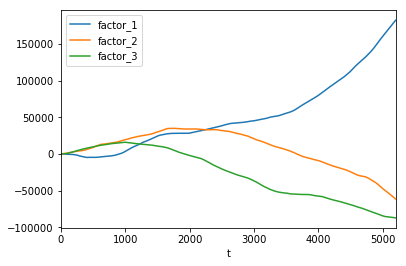

In [64]:
% matplotlib inline
from matplotlib import pyplot as plt
data.groupby('t')[[c for c in data.columns.values if 'factor_' in c]].mean().plot()

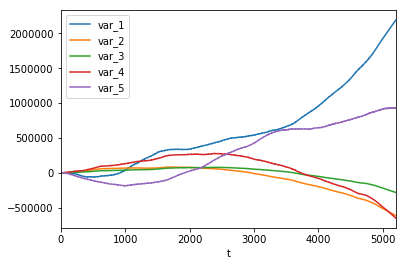

In [65]:
% matplotlib inline
from matplotlib import pyplot as plt
data.groupby('t')[[c for c in data.columns.values if 'var_' in c]].mean().plot()

# Rewrite as SSM (assuming weekly data)

$$
z_t\equiv 
\begin{bmatrix}
\alpha_t \\
\beta_t \\
\gamma_t \\
\vdots \\
\gamma_{t-50} \\
\end{bmatrix}_{(2+51)p\times1},
v_t\equiv 
\begin{bmatrix}
\epsilon_t\\
\eta_t \\
\xi_t\\
0
\end{bmatrix}_{(2+51)p\times1} \\
C\equiv 
\begin{bmatrix}
I_p & I_p & 0 & 0 & 0  \\
0 & I_p & 0 & 0 & 0 \\
0 & 0 & -I_p & \cdots & -I_p \\
0 & 0 & I_p & 0 & 0 \\
0 & 0 & 0 & I_{49} & 0 \\
\end{bmatrix}_{(2+51)p\times(2+51)p}, \\
\Sigma_{v}\equiv 
\begin{bmatrix}
\Sigma_{\epsilon} & 0 & 0 & 0 \\
0 & \Sigma_{\eta} & 0 & 0\\
0 & 0 & \Sigma_{\xi} & 0 \\
0 & 0 & 0 & 0_{50p}\\
\end{bmatrix}_{(2+51)p\times(2+51)p} \\ 
A\equiv 
\begin{bmatrix}
L_{n\times p} & 0_{n\times p} & L_{n\times p} & 0_{n\times 50p}
\end{bmatrix}_{n\times p(2+51)}\\
D\equiv 0, w_t\equiv 0 \\
B\equiv
\begin{bmatrix}
LD^* & B^*
\end{bmatrix}_{n\times(k_{w^*}+k_{x^*})},
x_t\equiv
\begin{bmatrix}
W_t^* \\
x_t^*
\end{bmatrix}_{n\times(k_{w^*}+k_{x^*})}
$$





# The Kalman filter and Smoother for the SSM



In [66]:
from numpy.linalg import pinv
def _check_symmetry_(x):
    if (x.T == x).all():
        return True
    else:
        return False
from numba import jit
@jit
def _make_symmetric_(x):
    for i in range(len(x)-1):
        for j in range(i+1,len(x)):
            x[i,j] = x[j,i]
    return x
def inv(x):
    return _make_symmetric_(pinv(x))

# General state space kalman filtering/smoothing

## Filtering: forward filter to calculated predictive states $z_{t|t-1}$ and state variances $var(z_{t|t-1})$ for t=1,...,T

Initialize $z_{1|0}=C\mu_0+Dw_1$ and $var(z_{1|0})=C\Sigma_0C'+\Sigma_v$

For t=1,..,T-1, predict $z_{t|t-1}$ and $var(z_{t|t-1})$ let $Q_t\equiv var(z_{t|t-1})$:

1. $\dot{H_t}=A'[A Q_tA'+\sigma_u]^{-1}$ (keep track of this)
2. $\dot{K_t}=CQ_t\dot{H_t}$ (Throw away) 
3. $L_t=C-\dot{K_t}A$ (keep this)
4. $z_{t+1|t}=L_tz_{t|t-1}+\dot{K_t}(y_t-Bx_t)+Dw_{t+1}$ (Keep this, obviously)
5. $Q_{t+1}=L_tQ_{t}C'+\Sigma_v$ (Keep this, obviously)

## Smoothing: backward smoother to estimate underlying states, $z_{t|T}$, and state covariances $S_{t-1}\equiv cov(z_{t|T}, z_{t-1|T})$ for t = T,T-1,..,0

Initialize the states $r_T=0$ and $R_t=0$

For $t=T,T-1,...,1$, calculate $z_{t|T}$, $var(Z_{t|T})$, and $cov(Z_{t|T}$,  $Z_{t-1|T})$:

1. $r_{t-1}=\dot{H_t}(y_t-Az_{t|t-1}-Bx_t)+L_t'r_t$ (throw away after iteration)
2. $R_{t-1}=\dot{H_t}A+L_t'R_tL_t$ (can be thrown away)
3. $z_{t|T}=z_{t|t-1}+Q_tr_{t-1}$ (use $z$ and $Q$ from filtering step)
4. $var(z_t|T)=Q_t-Q_tR_{t-1}Q_t$

if $t\ge 2$: $s_{t-1}=[I-Q_tR_{t-1}]L_{t-1}Q_{t-1}$

For t=0:

* $z_{0|T}=\mu_0+\Sigma_0C'r_0$
* $var(z_0|T)=\Sigma_0-\Sigma_0C'R_0C\Sigma_0$
* $S_0=[I-Q_1R_{0}]C\Sigma_0$



## Likelihood function

* $\epsilon_t=y_t-Az_{t|t-1}-Bx_t$ (prediction error of KF)
* $var(\epsilon_t)=AQ_tA'+\Sigma_{\mu}$ (error variance of KF)

Likelihood on $Y$ and $X$

$$
-2lnL_{y,x}(\Theta)=nTln(2\pi)+\sum_{t=1}^Tln|var(\epsilon_{t}^\Theta)|+\sum_{t=1}^T{\epsilon_{t}^{\Theta}}'var(\epsilon_{t}^\Theta)^{-1}\epsilon_{t}^\Theta
$$



## EM algorithm for estimation

1. Specify the structure (transition matrices, error structure, etc.)
2. Set initial parameter values $\Theta^0\equiv \{\mu_0,\Sigma_0,A,B,C,D,\Sigma_{\mu},\Sigma_{v}\}$
    
    For iteration j =1,2,... 
3. Perform E step. Use Kalman filter to obtain $\{z_{t|t-1}\}$ and $\{Q_t\}$ and use the Kalman Smoother to obtained estimated $\{z_{t|T}\}$ and $S_t$
4. Compute the likelihood conditional on the observed data Y and X andd the filtered values $\{z_{t|t-1}\}$ and $\{Q_t\}$
    $$
-2lnL_{y,x}(\Theta^{j-1})=nTln(2\pi)+\sum_{t=1}^Tln|var(\epsilon_{t}^{\Theta^{j-1}})|+\sum_{t=1}^T{\epsilon_{t}^{\Theta^{j-1}}}'var(\epsilon_{t}^{\Theta^{j-1}})^{-1}\epsilon_{t}^{\Theta^{j-1}}
$$
5. Perform the M-step* by plugging in smoothed state variables to obtain $\Theta^j$, see below.
6. Repeat 3-5 to convergence in the likelihood. $\delta<1e-6$
7. Standard errors can be derived by evaluating the Hessian at $\theta^j$ for the likelihood function where
    $$
-2lnL_{y,x}(\Theta^{j})=nTln(2\pi)+\sum_{t=1}^Tln|var(\epsilon_{t}^{\Theta^{j}})|+\sum_{t=1}^T{\epsilon_{t}^{\Theta^{j}}}'var(\epsilon_{t}^{\Theta^{j}})^{-1}\epsilon_{t}^{\Theta^{j}}
$$

## Deriving the M-step

Given the observed data $(Y,X)$ and the unobserved latent states (Z), we can rewrite the ll function as:

$$
-2lnL_{Y,X,Z}(\Theta)\propto ln|\Sigma_0|+(z_0-\mu_0)+Tln|\Sigma_v|+\sum_{t-1}^T(z_{t}-Cz_{t-1}-Dw_t)'\Sigma_{v}^{-1}(z_t-Cz_{t-1}-Dw_t)+Tln|\Sigma_mu|+\sum_{t1}^T(y_t-Az_t-Bx_t)'\sigma_{mu}^{-1}(y_t-Az_t-Bx_t)
$$


### M-step formulae for the general SSM (no parameter space structural restrictions):

* $\mu_0=z_{0|t}$
* $\Sigma_0 = var(z_{0|T})$
* $A=\big[\sum_{t=1}^T(y_t-Bx_t)z_{t|T}'\big]\big[\sum_{t=1}^Tx_tx_t'\big]^{-1}$
* $\Sigma_{u}=\frac{1}{T}\sum_{t=1}^T\big[(y_t-Az_{t|T}-Bx_t)(y_t-Az_{t|T}-Bx_t)'+AVar(z_{t|T}A')\big]$
* $C=\big[\sum_{t=1}^T(z_t-Dw_t)z_{t-1|T}'+cov(z_{t|T}, z_{t-1|T})\big]\big[\sum_{t=1}^Tz_{t-1|T}z_{t-1|T}'+var(z_{t-1|T})\big]^{-1}$
* $D=\big[\sum_{t=1}^T(z_{t|T}-Cz_{t-1|T})w_t'\big]\big[\sum_{t=1}^Tw_tw_t'\big]^{-1}$
* $
\begin{split}
\big[C\text{ } D\big]=    
    \begin{bmatrix}
    \sum_{t=1}^Tz_tz_{t-1}'+cov(z_{t|T},z_{t-1|T}) & \sum_{t=1}^Tz_{t|T}w_t'
    \end{bmatrix}
    \begin{bmatrix}
    \sum_{t=1}^Tz_{t-1|T}z_{t-1|T}'+var(z_{t-1|T}) & \sum_{t=1}^Tz_{t-1|T}w_t' \\
    \sum_{t=1}^Tw_tz_{t-1|T}' & \sum_{t=1^Tw_tw_t'}
    \end{bmatrix}
    \end{split}
    $
* $\Sigma_v=\frac{1}{T}\sum_{t=1}^T\bigg[(z_{t|T}-Cz_{t-1|T}-Dw_t)(z_{t|T}-Cz_{t-1|T}-Dw_t)'+var(z_{t|T})+Cvar(z_{t-1|T})C'-cov(z_{t|T},z_{t-1|T})C'-Ccov(z_{t|T},z_{t-1|T})'\bigg]$

## Structure imposed on parameter space for DyFactor model

#### Model parsimony and interpretability (structure on shocks)
1. $\Sigma_{\mu}$, the covariance of the shocks in measurement equations is assumed to be diagonal (uncorrelated observation shocks across observed time series).
2. $\Sigma_{\epsilon}$, the covariance of the shocks in the level components of the state equations is assumed to be $p\times p$ identity matrix
3. $\Sigma_{\eta}$, the covariance of the shocks in the slope components of the state equations is assumed to be diagonal.
4. $\Sigma_{\xi}$, the covariance matrix of shocks in the seasonal components of the state equations is assumed to be diagonal

#### Assumptions on model identification and stability/robustness
1. $\alpha_0$, the initial value of the level component is set to 0
    * In practice, a potentially more stable alternative is to demean $\alpha_0$ trough $\alpha_T$ at the end of each E stemp (smoother)
2. $\beta_0$ and $\gamma_0$ are model parameters to be estimated
3. $\Sigma_{a0}, \Sigma_{\beta 0}$ and $\Sigma_{\gamma 0}$ may or may not need to be fixed to a large value relative to $\mu_0$ (say 4 or 10)
    * test this
4. $w_t^*$ does not contain a colun of 1's or a column of t's
5. $x_t^*$ contains a column of 1's and does not contain a column of t's
6. L, the factor loadings matrix in the observation equations is identified up to an orthogonal rotation (Varimax rotation is orthogonal, i.e. $H^{-1}=H'$. One way to constrain it is to let $L_{jp}=0$ for p>j
     In practice L does not need to be constrained in estimation (locally identifiable) and a Varimax rotation afterwards will lead to a unique loadings matrix
     


## M-step for dynamic factor model

$$
\begin{split}
E_z\bigg[-2lnL_{Y,Z}(\Theta^{j-1})\bigg] &\propto \\
& ln|\Sigma_0|+E_z\big[\big(z_0-\mu_0\big)'\Sigma_0^{-1}(z_0-\mu_0)\big]\\
& +Tln|\Sigma_v|+E_z\big[\sum_{t=1}^T(z_t-Cz_{t-1}-Dw_t)'\Sigma_v^{-1}(z_t-Cz_{t-1}-Dw_t)\big] \\
& + Tln|\Sigma_{\mu}|+E_z\big[\sum_{t=1}^T(y_t-Az_{t}-Bx_t)'\Sigma_{\mu}^{-1}(y_t-Az_{t}-Bx_t)\big]
\end{split}
$$

The MLE step results in the following parameter estimates:

* $\mu_0=z_{0|T}$
* $\Sigma_0=diag[var(z_{0|T})]$
* $A_{\alpha \gamma}\equiv \begin{bmatrix}I_{p\times p}& 0_{p\times p }& I_{p\times p}& 0_{p\times50p}\end{bmatrix}$
* $z_{t|T;p\times1}^{*}\equiv A_{\alpha\gamma}z_{t|T}+D^{*}w_t^{*}$
* ${L^{h}}_{(1\times p)}=\big[\sum_{t=1}^T(y_t^h-B^{*h}x_t^{*}){z_{t|T}^{*}}'\big]\big[\sum_{t=1}^Tz_{t|T}^{*}{z_{t|T}^{*}}'+A_{\alpha\gamma}var(z_{t|T})A_{\alpha\gamma}'\big]$
* ${B^{*h}}_{(1\times k_{x^*})}=\big[\sum_{t=1}^T*(y_t^{h}-L^hz_{t|T}^{*}){x_t^{*}}'\big]\big[\sum_{t=1}^Tx_t^*{x_t^*}'\big]^{-1}$
* $\begin{bmatrix}
L^h & B^{*h}
\end{bmatrix}=
\begin{bmatrix}
\sum_{t=1}^{T}y_t^h{z_{t|T}^{*}}'&\sum_{t=1}^{T}y_t^h{x_{t|T}^{*}}'
\end{bmatrix}
\begin{bmatrix}
\sum_{t=1}^Tz_{t|T}^{*}{z_{t|T}^{*}}'+A_{\alpha\gamma}var(z_{t|T})A_{\alpha\gamma}' &
\sum_{t=1}^Tz_{t|T}^*{x_t^*}' \\
\sum_{t=1}^Tx_t^*{z_{t|T}}' & \sum_{t=1}^Tx_t^*{x_t^*}'
\end{bmatrix}^{-1}$
* $\Sigma_u^h=\frac{1}{T}\sum_{t=1}^T\big[(y_t^h-L^hz_{t|T}^*-B^{*h}x_t^*)(y_t^h-L^hzz_{t|T}^*-B^{*h}x_t^{*})'+(L^hA_{\alpha\gamma})var(z_{t|T})(L^hA_{\alpha\gamma})'\big]$
* ${D^*}_{(p\times k_{w^*})}=
\begin{bmatrix}
\sum_{h=1}^n\frac{{L^h}'L^h}{\Sigma_u^h}
\end{bmatrix}^{-1}
\begin{bmatrix}
\frac{{L^h}'\sum_{t=1}^T(y_t^h-L^hA_{\alpha\gamma}z_{t|T}-B^{*h}x_t^*){w_t^*}'}{\Sigma_u^h}
\end{bmatrix}
\begin{bmatrix}
\sum_{t=1}^Tw_t^*{w_t^*}'
\end{bmatrix}^{-1}$
* $\Sigma_{\epsilon}=I_p$
* $\Sigma_{\eta}^{\beta_j}=\frac{1}{T}\sum_{t=1}^T\bigg[(z_{t|T}^{\beta_j}-C^{\beta_j}z_{t-1|T})(z_{t|T}^{\beta_j}-C^{\beta_j}z_{t-1|T})'+I^{\beta_j}var(z_{t|T})I^{{\beta_j}'}+C^{\beta_j}var(z_{t-1|T})C^{{\beta_j}'}-I^{\beta_j}cov(z_{t|T},z_{t-1|T})C^{{\beta_j}'}+C^{\beta_j}cov(z_{t|T},z_{t-1|T})I^{{\beta_j}'}\bigg]$
* $\Sigma_{\xi}^{\gamma_j}=\frac{1}{T}\sum_{t=1}^T\bigg[(z_{t|T}^{\gamma_j}-C^{\gamma_j}z_{t-1|T})(z_{t|T}^{\gamma_j}-C^{\gamma_j}z_{t-1|T})'+I^{\gamma_j}var(z_{t|T})I^{{\gamma_j}'}+C^{\gamma_j}var(z_{t-1|T})C^{{\gamma_j}'}-I^{\gamma_j}cov(z_{t|T},z_{t-1|T})C^{{\gamma_j}'}+C^{\gamma_j}cov(z_{t|T},z_{t-1|T})I^{{\gamma_j}'}\bigg]$

# Code for Estimation Class KF_DFM

In [67]:
from numpy import dot
from numpy.linalg import pinv, norm,inv
class KF_DFM(object):
    def __init__(self,y,x,W,Sigma_u,Sigma_v,A,B,C,D, p=2, n = 'default',sig0=5):
        self.p = p
        if n == 'default':
            self.n = y.shape[1]
        else:
            self.n = n
        self.mu_0 = np.zeros([C.shape[0], 1])
        self.Sigma_0 = np.eye(C.shape[0])*sig0
        self.Sigma_u = Sigma_u
        self.Sigma_v = Sigma_v
        self.ll = None
        if len(y.shape)!=3:
            self.y = y.reshape([y.shape[0], y.shape[1], 1])
        else:
            self.y = y
        try:
            if len(x.shape)!=3:
                self.x = x.reshape([x.shape[0], x.shape[1], 1])
            else:
                self.x = x
        except:
            self.x = None
        
        self.A = A
        self.B = B
        self.C = C
        self.D = D
    
    def kfilter(self, returns = False):        
        Hs=list()
        Ls=list()
        zs=list()
        Qs=list()
        if (self.D == None) | (np.count_nonzero(self.D)==0):
            z=dot(self.C,self.mu_0)
        else:
            z=dot(self.C,self.mu_0)+dot(self.D, self.W[0])
        Q=dot(self.C,dot(self.Sigma_0,self.C.T))+self.Sigma_v
        zs.append(z)
        Qs.append(Q)
        for t in range(len(self.y)):
            H_t_dot = dot(self.A.T, inv(dot(dot(self.A,Q), self.A.T)+self.Sigma_u))
            K_t_dot=dot(dot(self.C,Q),H_t_dot)
            L_t = self.C-dot(K_t_dot,self.A)
            if ((self.D == None) | (np.count_nonzero(self.D)==0))&((self.B == None) | (np.count_nonzero(self.B)==0)):
                z = dot(L_t,z)+dot(K_t_dot,self.y[t])
            elif (self.D == None) | (np.count_nonzero(self.D)==0):
                z = dot(L_t,z)+dot(K_t_dot,(self.y[t]-dot(self.B,self.x[t])))
            elif (self.B == None) | (np.count_nonzero(self.B)==0):
                z = dot(L_t,z)+dot(K_t_dot,self.y[t])+dot(self.D,self.w[t])
            else:
                z = dot(L_t,z)+dot(K_t_dot,(self.y[t]-dot(self.B,self.x[t])))+dot(self.D,self.w[t])
            Q=dot(dot(L_t,Q),self.C.T)+self.Sigma_v
            Hs.append(H_t_dot)
            Ls.append(L_t)
            zs.append(z)
            Qs.append(Q)
            
        self.Hs = Hs
        self.Ls = Ls
        self.zs = zs
        self.Qs = Qs
        if returns == True:
            return self.zs, self.Qs
    def ksmoother(self, returns = False):
        zsmooth = list()
        zvarsmooth = list()
        zcovarsmooth = list()
        rs = list()
        r = np.zeros(self.zs[0].shape)
        R = np.zeros(self.Qs[0].shape)
        I = np.eye(self.zs[-1].shape[0])
        for t in range(len(self.y))[::-1]:
            H_t_dot = self.Hs[t]
            y_t = self.y[t]
            if self.x != None:
                x_t = self.x[t]
            z = self.zs[t]
            Q=self.Qs[t]
            L_t=self.Ls[t]
            if (self.B == None) | (np.count_nonzero(self.B)==0):
                r = dot(H_t_dot,y_t-dot(self.A,z))+dot(L_t.T,r)
            else:
                r = dot(H_t_dot,(y_t-dot(self.A,z)-dot(self.B,x_t)))+dot(L_t.T,r)
            R = dot(H_t_dot,self.A)+dot(dot(L_t.T, R), L_t)
            if t ==0:
                r0 = r
                R0 = R
            z_T = z+dot(Q,r)
            var_z_T = Q-dot(dot(Q,R),Q)
            if t>=1:
                s_t_1 = dot(dot((I-dot(Q,R)),L_t),self.Qs[t-1])
                zcovarsmooth.append(s_t_1)
            zsmooth.append(z_T)
            zvarsmooth.append(var_z_T)
            rs.append(r)
        z_T=self.mu_0+dot(dot(self.Sigma_0,self.C.T), r0)
        var_z_T=self.Sigma_0-dot(dot(dot(dot(self.Sigma_0,self.C.T),R0),self.C),self.Sigma_0)
        S_0 = dot(dot(I-dot(Q,R0), self.C),self.Sigma_0)
        zsmooth.append(z_T)
        zvarsmooth.append(var_z_T)
        zcovarsmooth.append(S_0)
        self.zsmooth = zsmooth[::-1]
        self.zvarsmooth = zvarsmooth[::-1]
        self.zcovarsmooth = zcovarsmooth[::-1]
        self.rs = rs[::-1]
        if returns == True:
            return self.zsmooth
    def maximize(self, compute_ll=False):
        A,B,C,D = self.A, self.B, self.C, self.D
        p = self.p
        seasons =int((self.C.shape[0]-p*2)/p+1)
        mu_0 = self.zsmooth[0]
        Sigma_0 = np.diag(np.diag(self.zvarsmooth[0]))
        A_alphagamma = np.concatenate([np.eye(p), 
                                       np.zeros([p,p]), 
                                       np.eye(p), 
                                       np.zeros([p,(seasons-2)*p])], 
                                      axis = 1) # level+season state opeartor
        
        Z_T_star = [dot(A_alphagamma,zT) for zT in self.zsmooth[1:]] # Get State combined state level
        
        # Compute loading factors
        if (self.B != None):
            # upper block 
            v2_1 = np.concatenate([sum([dot(zt, zt.T)
                                        +dot(dot(A_alphagamma,self.zvarsmooth[i+1]),A_alphagamma.T) 
                                        for i,zt in enumerate(Z_T_star)]),
                                   sum([dot(zt, self.x[i].T) 
                                        for i,zt in enumerate(Z_T_star)])])
            # Bottom block
            v2_2 = np.concatenate([sum([dot(self.x[i], zt.T) for i,zt in enumerate(Z_T_star)]),
                                   sum([dot(self.x[i], self.x[i].T) for i,zt in enumerate(Z_T_star)])])
            v2 = np.concatenate([v2_1, v2_2], axis = 0)
        else:
            v2 = sum([dot(zt, zt.T)+dot(dot(A_alphagamma,self.zvarsmooth[i+1]),A_alphagamma.T) 
                      for i,zt in enumerate(Z_T_star)])
        # Compute loading factors    
        LBs = list()
        Ls = list()
        Bs = list()
        if (self.B != None):
            for h in range(len(self.y[0])):
                v1 = np.concatenate([sum([dot(self.y[t][h],zt.T) 
                                          for i,zt in enumerate(Z_T_star)]),
                                     sum([dot(self.y[t][h],xt.T) 
                                          for i,xt in enumerate(self.x)])], axis = 1)
                LB = dot(v1, v2)
                LBs.append(LB)
                Ls.append(LB[:p])
                Bs.append(LB[p:])
        else:
            for h in range(len(self.y[0])):
                v1 = sum([dot(self.y[t][h],zt.T) 
                          for t,zt in enumerate(Z_T_star)])
                LB = dot(v1,inv(v2))
                LBs.append(LB)
            Ls = LBs
            
        # Sigma_u (observation covariance)
        Sig_u = list()
        for h in range(len(self.y[0])):
            if self.B!= None:
                sig_u_h = 1/len(self.y)*sum([dot((self.y[i][h]-dot(Ls[h],zt)-dot(Bs[h],self.x[i])),
                                              (self.y[i][h]-dot(Ls[h],zt)-dot(Bs[h],self.x[i])).T) 
                                          +dot(dot(dot(Ls[h],A_alphagamma),self.zvarsmooth[i+1]),
                                              dot(Ls[h],A_alphagamma).T)
                                          for i,zt in Z_T_star])
            else:
                sig_u_h = 1/len(self.y)*sum([dot(self.y[i][h]-dot(Ls[h],zt),
                                              (self.y[i][h]-dot(Ls[h],zt)).T) 
                                          +dot(dot(dot(Ls[h],A_alphagamma),self.zvarsmooth[i+1]),
                                              dot(Ls[h],A_alphagamma).T)
                                          for i,zt in enumerate(Z_T_star)])
            Sig_u.append(sig_u_h)
        Sig_u = np.diag(Sig_u)

        # State space covariances 
        Ibetas = np.eye(p,len(self.zsmooth[1]))
        Sigma_eta_betas = list()
        for j in range(p):
            Cbeta = C[p+j,:]
            Ibeta = Ibetas[j]
            Sigma_eta_beta = 1/len(self.y)*sum([dot((zT[p+j]-dot(Cbeta, self.zsmooth[i])), 
                                                    (zT[p+j]-dot(Cbeta, self.zsmooth[i])).T)
                                                +dot(dot(Ibeta, self.zvarsmooth[i+1]), Ibeta.T)
                                                +dot(dot(Cbeta, self.zvarsmooth[i]), Cbeta.T)
                                                -dot(dot(Ibeta, self.zcovarsmooth[i]), Cbeta.T)
                                                -dot(dot(Cbeta, self.zcovarsmooth[i]), Ibeta.T) 
                                                for i,zT in enumerate(self.zsmooth[1:])])
            Sigma_eta_betas.append(Sigma_eta_beta)
        sigma_eta=np.diag(Sigma_eta_betas)


        Igammas = np.eye(seasons-1,len(self.zsmooth[1]))
        Sigma_xi_gammas = list()
        for j in range(p):
            Cgamma = C[-(seasons-1)+j,:]
            Igamma = Igammas[j]
            Sigma_xi_gamma = 1/len(self.y)*sum([dot((zT[-(seasons-1)+j]-dot(Cgamma, self.zsmooth[i])), 
                                                    (zT[-(seasons-1)+j]-dot(Cgamma, self.zsmooth[i])).T)
                                                +dot(dot(Igamma, self.zvarsmooth[i+1]), Igamma.T)
                                                +dot(dot(Cgamma, self.zvarsmooth[i]), Cgamma.T)
                                                -dot(dot(Igamma, self.zcovarsmooth[i]), Cgamma.T)
                                                -dot(dot(Cgamma, self.zcovarsmooth[i]), Igamma.T) for i,zT in enumerate(self.zsmooth[1:])])
            Sigma_xi_gammas.append(Sigma_xi_gamma)
        sigma_xi=np.diag(Sigma_xi_gammas)
        
        sigma_epsilon  = np.eye(p) # level state covariances are assumed identity(p)
        ##### Clean up ######
        # Construct state covariance, Sigma_v
        SIG = block_diag(*[sigma_epsilon, sigma_eta, sigma_xi, np.zeros([(seasons-2)*p,(seasons-2)*p])])
        # Construct measurement matrix, A
        L = varimax(np.array(Ls),q=100)
        A = L
        for m in [np.zeros([self.n,p]), L, np.zeros([self.n,(seasons-2)*p])]:
            A = np.concatenate([A, m], axis = 1)
        
        # update model parameters
        self.Sigma_v = SIG
        self.sigma_eta = sigma_eta
        self.sigma_xi = sigma_xi
        self.L = L
        self.A = A
        self.Sigma_u = Sig_u
        self.mu_0 = mu_0
        self.Sigma_0 = Sigma_0
        if self.B != None:
            B = np.array(Bs)
            self.B = B
        if self.D != None:
            D = np.array(Ds)
            self.D = D
        
        # compute log likellihood
        if compute_ll == True:
            if (model.B!=None) &(model.D!=None):
                ll = sum([np.log(norm(Sigma_0)),
                         np.trace(dot(inv(Sigma_0),dot((model.zsmooth[0]-mu_0),(model.zsmooth[0]-mu_0).T)
                                      +model.zvarsmooth[0])),
                          len(model.y)*np.log(norm(SIG)),
                          np.trace(dot(inv(SIG),
                                      sum([dot((zt-dot(C,model.zsmooth[i])-dot(D,model.w[i])),
                                            (zt-dot(C,model.zsmooth[i])-dot(D,model.w[i])).T)
                                        +model.zvarsmooth[i+1]
                                        +dot(dot(C, model.zvarsmooth[i]), C.T)
                                        -dot(model.zcovarsmooth[i],C.T)
                                        -dot(C,model.zcovarsmooth[i])
                                        for i,zt in enumerate(model.zsmooth[1:])]))),
                          len(model.y)*np.log(norm(Sig_u)),
                          np.trace(dot(inv(Sig_u),
                                      sum([dot((model.y[i]-dot(A,zt)-dot(B,model.x[i])),
                                            (model.y[i]-dot(A,zt)-dot(B,model.x[i])).T)
                                        +dot(dot(A, model.zvarsmooth[i+1]), A.T)
                                        for i,zt in enumerate(model.zsmooth[1:])])))
                        ])
            elif (model.D!=None):
                ll = sum([np.log(norm(Sigma_0)),
                         np.trace(dot(inv(Sigma_0),dot((model.zsmooth[0]-mu_0),(model.zsmooth[0]-mu_0).T)
                                      +model.zvarsmooth[0])),
                          len(model.y)*np.log(norm(SIG)),
                          np.trace(dot(inv(SIG),
                                      sum([dot((zt-dot(C,model.zsmooth[i])-dot(D,model.w[i])),
                                            (zt-dot(C,model.zsmooth[i])-dot(D,model.w[i])).T)
                                        +model.zvarsmooth[i+1]
                                        +dot(dot(C, model.zvarsmooth[i]), C.T)
                                        -dot(model.zcovarsmooth[i],C.T)
                                        -dot(C,model.zcovarsmooth[i])
                                        for i,zt in enumerate(model.zsmooth[1:])]))),
                          len(model.y)*np.log(norm(Sig_u)),
                          np.trace(dot(inv(Sig_u),
                                      sum([dot((model.y[i]-dot(A,zt)),
                                            (model.y[i]-dot(A,zt)).T)
                                        +dot(dot(A, model.zvarsmooth[i+1]), A.T)
                                        for i,zt in enumerate(model.zsmooth[1:])])))
                         ])
            elif (model.B!=None):
                ll = sum([np.log(norm(Sigma_0)),
                         np.trace(dot(inv(Sigma_0),dot((model.zsmooth[0]-mu_0),(model.zsmooth[0]-mu_0).T)
                                      +model.zvarsmooth[0])),
                          len(model.y)*np.log(norm(SIG)),
                          np.trace(dot(inv(SIG),
                                      sum([dot((zt-dot(C,model.zsmooth[i])),
                                            (zt-dot(C,model.zsmooth[i])).T)
                                        +model.zvarsmooth[i+1]
                                        +dot(dot(C, model.zvarsmooth[i]), C.T)
                                        -dot(model.zcovarsmooth[i],C.T)
                                        -dot(C,model.zcovarsmooth[i])
                                        for i,zt in enumerate(model.zsmooth[1:])]))),
                          len(model.y)*np.log(norm(Sig_u)),
                          np.trace(dot(inv(Sig_u),
                                      sum([dot((model.y[i]-dot(A,zt)-dot(B,model.x[i])),
                                            (model.y[i]-dot(A,zt)-dot(B,model.x[i])).T)
                                        +dot(dot(A, model.zvarsmooth[i+1]), A.T)
                                        for i,zt in enumerate(model.zsmooth[1:])])))
                        ])
            else:
                ll = sum([np.log(norm(Sigma_0)),
                         np.trace(dot(inv(Sigma_0),dot((model.zsmooth[0]-mu_0),(model.zsmooth[0]-mu_0).T)
                                      +model.zvarsmooth[0])),
                          len(model.y)*np.log(norm(SIG)),
                          np.trace(dot(inv(SIG),
                                      sum([dot((zt-dot(C,model.zsmooth[i])),
                                            (zt-dot(C,model.zsmooth[i])).T)
                                        +model.zvarsmooth[i+1]
                                        +dot(dot(C, model.zvarsmooth[i]), C.T)
                                        -dot(model.zcovarsmooth[i],C.T)
                                        -dot(C,model.zcovarsmooth[i])
                                        for i,zt in enumerate(model.zsmooth[1:])]))),
                          len(model.y)*np.log(norm(Sig_u)),
                          np.trace(dot(inv(Sig_u),
                                      sum([dot((model.y[i]-dot(A,zt)),
                                            (model.y[i]-dot(A,zt)).T)
                                        +dot(dot(A, model.zvarsmooth[i+1]), A.T)
                                        for i,zt in enumerate(model.zsmooth[1:])])))
                        ])

            if self.ll!= None:
                print 'Change in ll {}'.format(ll-self.ll)
            else: 
                print 'll: {}'.format(ll)
            self.ll = ll
    def EM(self, iters = 10, compute_ll=False, IterPrint = True):
        for it in range(iters):
            self.kfilter()
            self.ksmoother()
            self.maximize(compute_ll=compute_ll)
            if IterPrint == True:
                print 'Iteration: {}'.format(it)

In [68]:
y = np.array(data[[c for c in data.columns.values if 'var_' in c]])
model = KF_DFM(y,None,None,sigma_mu,SIG,A,None,C,None, p=3, n = 'default')
zfilt,zvarfilt = model.kfilter(returns = True)
zsmooth = model.ksmoother(returns = True)

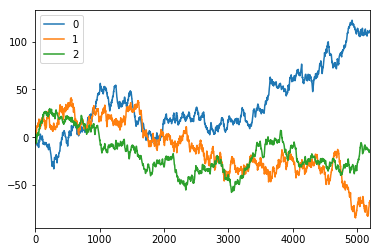

In [69]:
pd.DataFrame([zs.reshape(len(zs))[p:2*p] for zs in zsmooth]).plot()

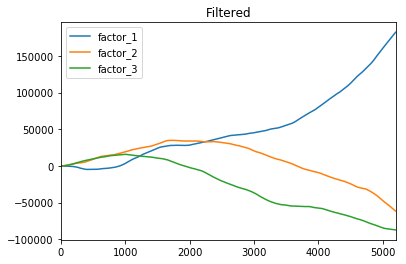

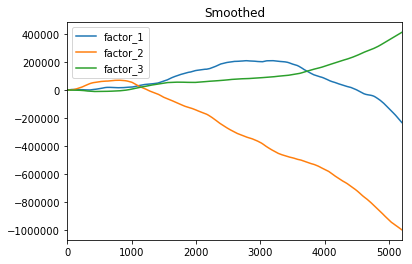

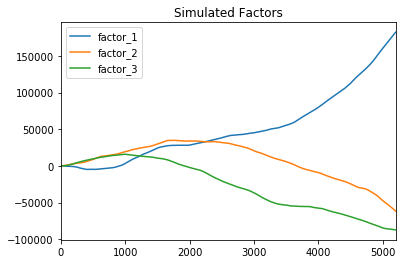

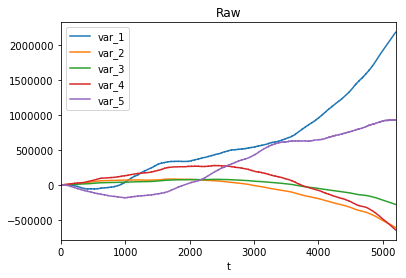

In [75]:
# zfilt,zvarfilt = model.kfilter(returns = True)
# zsmooth = model.ksmoother(returns = True)
Zfilt = pd.DataFrame([zf.reshape(len(zf))[:p] for zf in zfilt])
Zfilt.columns = ['factor_'+str(c+1) for c in range(3)]
Zfilt.plot(title = 'Filtered')
plt.savefig('./DFM_Test_Files/em_filtered.png')
Zsmooth = pd.DataFrame([zs.reshape(len(zs))[:p] for zs in zsmooth])
Zsmooth.columns = ['factor_'+str(c+1) for c in range(3)]
Zsmooth.plot(title = 'Smoothed')
plt.savefig('./DFM_Test_Files/em_smoothed.png')
Z.plot(title = 'Simulated Factors')
plt.savefig('./DFM_Test_Files/truefactors.png')
data.groupby('t')[[c for c in data.columns.values if 'var_' in c]].mean().plot(title = 'Raw')
plt.savefig('./DFM_Test_Files/rawdata.png')


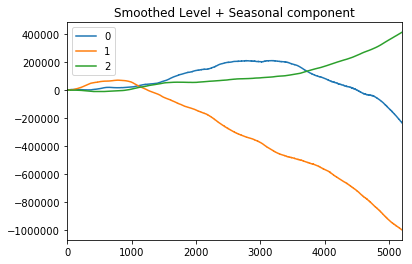

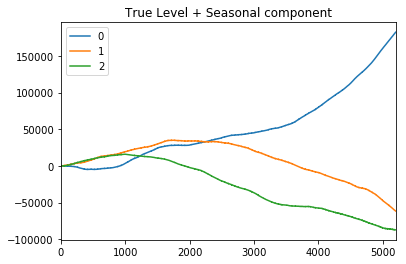

In [76]:
pd.DataFrame([zs.reshape(len(zs))[:p]+zs.reshape(len(zs))[2*p:2*p+3] for zs in zsmooth])[1:].plot()
plt.title('Smoothed Level + Seasonal component')
pd.DataFrame([zs.reshape(len(zs))[:p]+zs.reshape(len(zs))[2*p:2*p+3] for zs in Zts]).plot()
plt.title('True Level + Seasonal component')

In [ ]:
# Random guess for measurement matrix
L = np.random.normal(0,2, [n,p])
Astart = L
for m in [np.zeros([n,p]), np.random.normal(0,2, [n,p]), np.zeros([n,(seasons-2)*p])]:
    Astart = np.concatenate([Astart, m], axis = 1)
# Specify model
model = KF_DFM(y,None,None,np.eye(n),np.eye(SIG.shape[0]),Astart,None,C,None, p=3, n = 'default',sig0=5)
model.EM(iters = 20)
# Plot latent factors
zsmooth = model.zsmooth
pd.DataFrame([zs.reshape(len(zs))[:p]+zs.reshape(len(zs))[2*p:2*p+3] for zs in zsmooth])[1:].plot()
plt.title('Smoothed Level + Seasonal component')
plt.legend = ['Factor {}'.format(i) for i in range(p)]
pd.DataFrame([zs.reshape(len(zs))[:p]+zs.reshape(len(zs))[2*p:2*p+3] for zs in Zts]).plot()
plt.title('True Level + Seasonal component')
plt.legend = ['Factor {}'.format(i) for i in range(p)]

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9


In [80]:
varimax(model.L),varimax(L), model.L,L

(array([[ 0.29805391, -0.03426997,  5.39578608],
        [ 0.99058167,  0.78082797,  0.96845062],
        [ 0.68696987,  0.367512  ,  0.59965048],
        [ 2.14355231,  1.25021302,  2.67451405],
        [-0.72902146, -2.52124021, -4.25620954]]),
 array([[ 11.97970234,  -0.66019984,   0.2255394 ],
        [ -1.78020997,   4.09990922,   0.1469586 ],
        [ -0.81471752,   3.09246584,  -0.87914186],
        [ -1.06142061,   9.16884462,  -1.91198186],
        [ -0.22208527,   0.96700285, -11.97604207]]),
 array([[ 0.29805391, -0.03426995,  5.39578608],
        [ 0.99058167,  0.78082798,  0.96845062],
        [ 0.68696987,  0.36751201,  0.59965048],
        [ 2.1435523 ,  1.25021304,  2.67451404],
        [-0.72902145, -2.52124023, -4.25620953]]),
 array([[ 12. ,   0. ,   0. ],
        [ -2. ,   4. ,   0. ],
        [ -1. ,   3. ,  -1. ],
        [ -1.6,   9. ,  -2.3],
        [ -0.5,   0.4, -12. ]]))

In [ ]:
zsmooth = model.zsmooth
pd.DataFrame([zs.reshape(len(zs))[:p]+zs.reshape(len(zs))[2*p:2*p+3] for zs in zsmooth])[1:].plot()
plt.title('Smoothed Level + Seasonal component')
plt.legend = ['Factor {}'.format(i) for i in range(p)]
pd.DataFrame([zs.reshape(len(zs))[:p]+zs.reshape(len(zs))[2*p:2*p+3] for zs in Zts]).plot()
plt.title('True Level + Seasonal component')
plt.legend = ['Factor {}'.format(i) for i in range(p)]

## Class maintains persistence, can just run EM again for a few more iterations...

In [77]:
model.EM(iters = 20, IterPrint = False) # Run for 20 more iterations

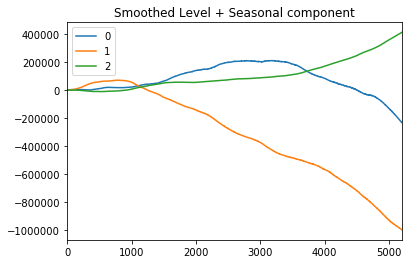

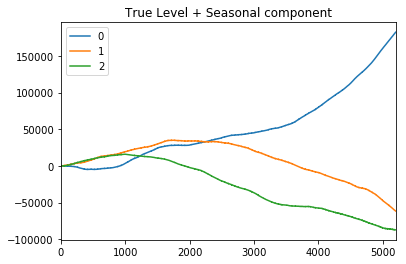

In [78]:
zsmooth = model.zsmooth
pd.DataFrame([zs.reshape(len(zs))[:p]+zs.reshape(len(zs))[2*p:2*p+3] for zs in zsmooth])[1:].plot()
plt.title('Smoothed Level + Seasonal component')
plt.legend = ['Factor {}'.format(i) for i in range(p)]
pd.DataFrame([zs.reshape(len(zs))[:p]+zs.reshape(len(zs))[2*p:2*p+3] for zs in Zts]).plot()
plt.title('True Level + Seasonal component')
plt.legend = ['Factor {}'.format(i) for i in range(p)]

In [79]:
varimax(model.L),varimax(L), model.L

(array([[ 0.29805391, -0.03426997,  5.39578608],
        [ 0.99058167,  0.78082797,  0.96845062],
        [ 0.68696987,  0.367512  ,  0.59965048],
        [ 2.14355231,  1.25021302,  2.67451405],
        [-0.72902146, -2.52124021, -4.25620954]]),
 array([[ 11.97970234,  -0.66019984,   0.2255394 ],
        [ -1.78020997,   4.09990922,   0.1469586 ],
        [ -0.81471752,   3.09246584,  -0.87914186],
        [ -1.06142061,   9.16884462,  -1.91198186],
        [ -0.22208527,   0.96700285, -11.97604207]]),
 array([[ 0.29805391, -0.03426995,  5.39578608],
        [ 0.99058167,  0.78082798,  0.96845062],
        [ 0.68696987,  0.36751201,  0.59965048],
        [ 2.1435523 ,  1.25021304,  2.67451404],
        [-0.72902145, -2.52124023, -4.25620953]]))